In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from util.functions import get_data_ticker, dias_uteis_entre_datas, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

EMPRESA = 'PETR4.SA'

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Obter dados

In [2]:
dados = get_data_ticker(EMPRESA, period='5y')
dados['Close_diff'] = dados['Close'].diff().dropna()
dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Decomposição

### Análises para descobrir o melhor "period"

#### ACF

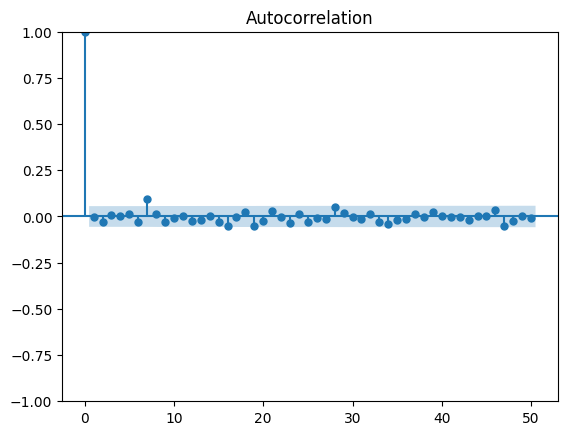

In [3]:
plot_acf(dados['Close_diff'], lags=50) 
plt.show()

### Seasonal decompose

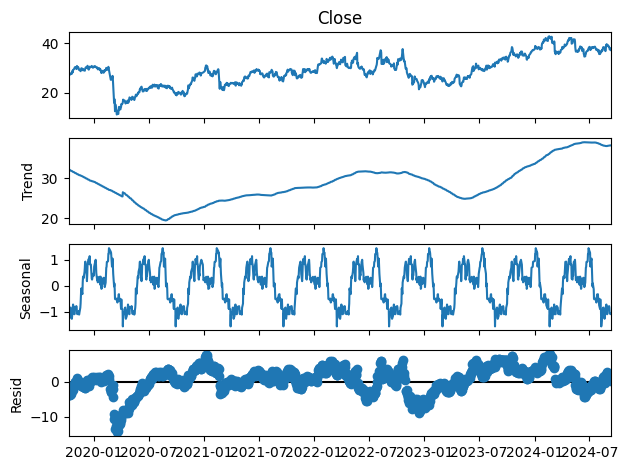

<Axes: xlabel='Date'>

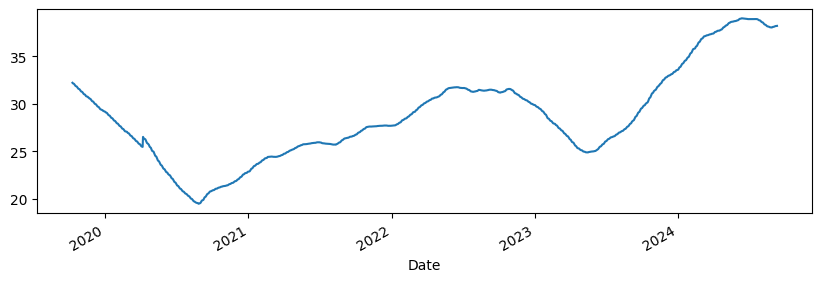

In [4]:
season = decompor_sinal(dados['Close'], period=120 )
tendencia = season.trend

season.plot()
plt.show()

plt.figure(figsize=(10,3))
tendencia.plot()

## Pré processamento

In [141]:
tendencia.dropna()
dados.loc[tendencia.dropna().index].copy()
dados['tomorrow'] = tendencia.shift(-1)
# dados.tail(15)

In [142]:
fig = px.line(dados, y='Close')
fig.show()

## Modelos

### Prophet

In [143]:
np.random.seed(42)

df_prophet = pd.DataFrame()
df_prophet['ds'] = dados.index
df_prophet['y'] = dados['Close'].reset_index(drop=True)

tamanho_treino = int(len(df_prophet)*.8)
tamanho_teste = int(len(df_prophet)*.2)

df_treino = df_prophet[:tamanho_treino]
df_teste = df_prophet[tamanho_treino:]

modelo_prophet = Prophet()
modelo_prophet.fit(df_treino)

futuro = modelo_prophet.make_future_dataframe(periods=len(df_teste), freq='D')
previsao = modelo_prophet.predict(futuro)

19:30:40 - cmdstanpy - INFO - Chain [1] start processing
19:30:40 - cmdstanpy - INFO - Chain [1] done processing


MSE: 75.23; RMSE: 8.67


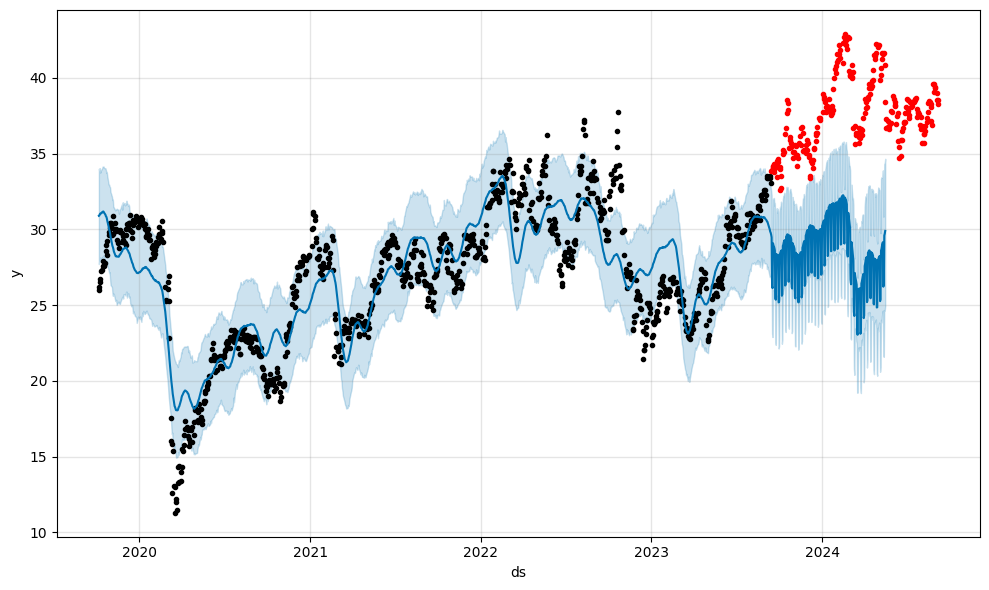

In [144]:
modelo_prophet.plot(previsao)

plt.plot(df_teste['ds'],df_teste['y'],'.r')

from sklearn.metrics import mean_squared_error

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds', how='inner')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}; RMSE: {rmse}')

In [145]:
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)

futuro = modelo_prophet.make_future_dataframe(periods=0, freq='D')
previsao = modelo_prophet.predict(futuro)

df_prophet_sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])]

modelo_prophet.plot()

19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:42 - cmdstanpy - INFO - Chain [1] done processing


TypeError: Prophet.plot() missing 1 required positional argument: 'fcst'

### LSTM